### CBam VGG16

In [1]:
%cd /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/

[Errno 2] No such file or directory: '/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/'
/content


In [2]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# from lr_finder import LRFinder
from utils.processing import data_processing
from utils import get_models
from utils.datasets import data_generator
from utils.processing import data_augmentation
from utils import predict

import json
import numpy as np
import keras
import tensorflow as tf
from keras import layers, Input
from keras.utils import np_utils 

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, ResNet50V2, MobileNetV2, MobileNetV2
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import load_model, Model



ModuleNotFoundError: ignored

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [ ]:
# Create input shape
img_size_target = 48
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])
img_conc

<KerasTensor: shape=(None, 48, 48, 3) dtype=float32 (created by layer 'concatenate_28')>

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
# from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
# in_lay = Input((128,128,3))
model = VGG16(input_shape = None, input_tensor = img_conc ,
                              include_top = False, weights = 'imagenet')
inputs = model.input 

net1 = model.layers[4].output
net2 = model.layers[7].output
net3 = model.layers[11].output
net4 = model.layers[16].output
net5 = model.layers[-1].output
##

att1 = attach_attention_module(net1, attention_module = "cbam_block")
# att2 = attach_attention_module(net2, attention_module = "cbam_block")
# att3 = attach_attention_module(net3, attention_module = "cbam_block")
# att4 = attach_attention_module(net4, attention_module = "cbam_block")
# att5 = attach_attention_module(net5, attention_module = "cbam_block")


x = keras.layers.add([net1, att1])
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = model.layers[5](x)
x = model.layers[6](x)
net22 = model.layers[7](x)

att2 = attach_attention_module(net22, attention_module = "cbam_block")
x = keras.layers.add([net22, att2])
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = model.layers[8](x)
x = model.layers[9](x)
x = model.layers[10](x)
net33 = model.layers[11](x)

att3 = attach_attention_module(net33, attention_module = "cbam_block")
x = keras.layers.add([net33, att3])
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = model.layers[12](x)
x = model.layers[13](x)
x = model.layers[14](x)
net44 = model.layers[15](x)

att4 = attach_attention_module(net44, attention_module = "cbam_block")
x = keras.layers.add([net44, att4])
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = model.layers[16](x)
x = model.layers[17](x)
x = model.layers[18](x)
net55 = model.layers[-1](x)


fcHead = GlobalAveragePooling2D()(net55)

fcHead = keras.layers.Dense(1024,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(fcHead)
fcHead = keras.layers.Activation('relu')(fcHead)
fcHead = keras.layers.Dropout(0.5)(fcHead)

fcHead = keras.layers.Dense(256,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(fcHead)
fcHead = keras.layers.Activation('relu')(fcHead)
fcHead = keras.layers.Dropout(0.5)(fcHead)

fcHead = keras.layers.Dense(128,  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(fcHead)
fcHead = keras.layers.Activation('relu')(fcHead)
fcHead = keras.layers.Dropout(0.5)(fcHead)

fcHead = keras.layers.Dense(7)(fcHead)
fcHead = keras.layers.Activation('Softmax')(fcHead)
model = keras.Model(inputs=inputs, outputs=fcHead)






In [ ]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate_28 (Concatenate)   (None, 48, 48, 3)    0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 48, 48, 64)   1792        ['concatenate_28[0][0]']         
                                                                                           

In [6]:
model = VGG16(input_shape = (224,224,3),
                              include_top = True, weights = 'imagenet')
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

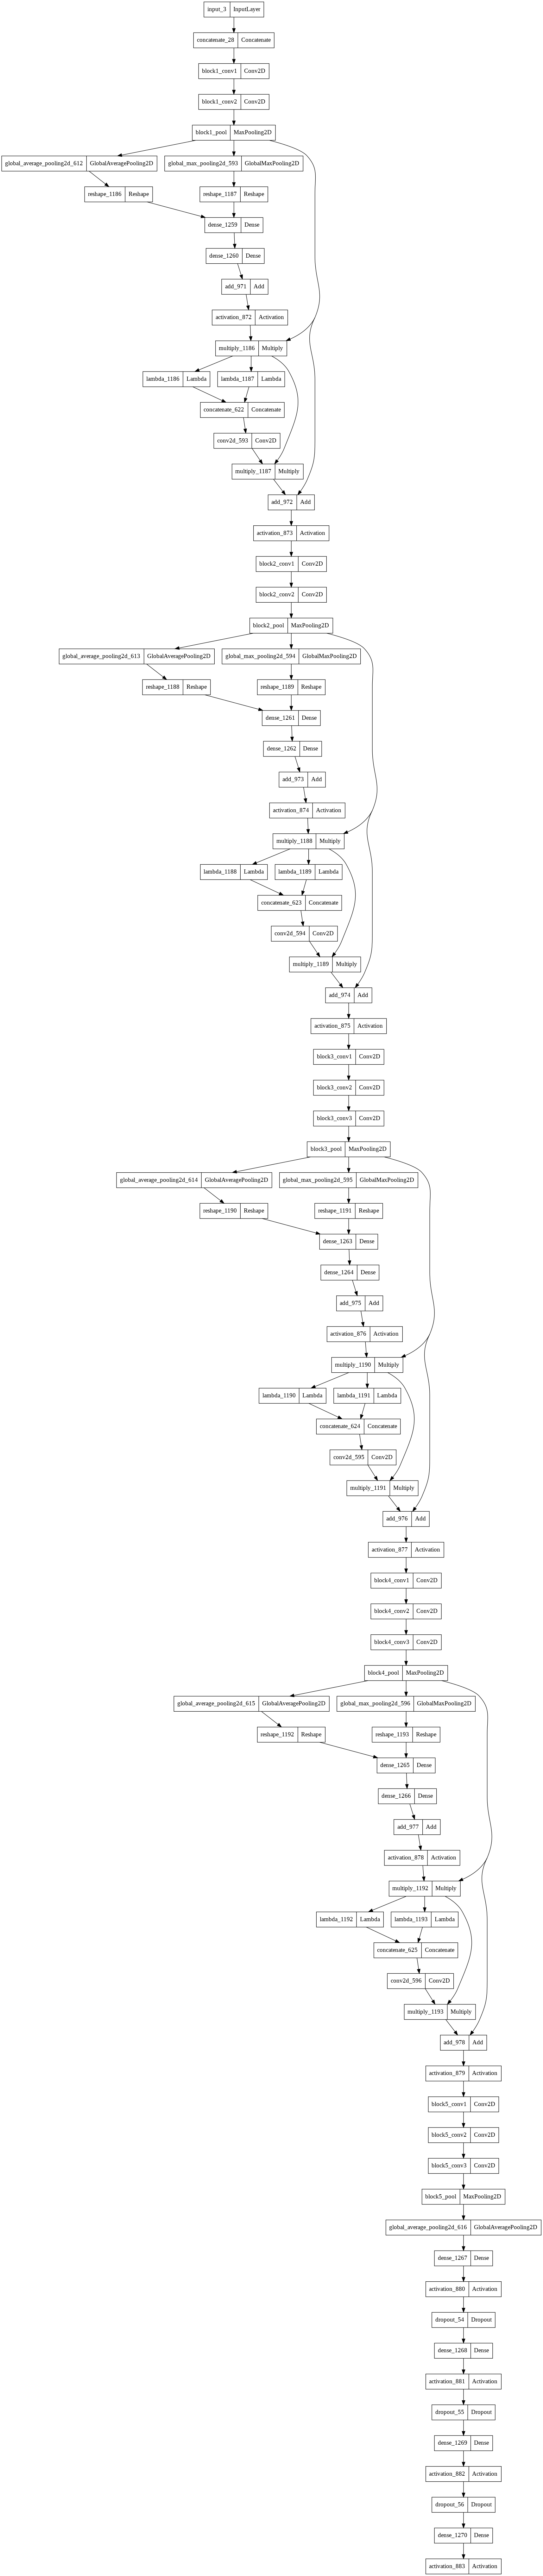

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)